# DLS Object Detection Project

## Импорты необходимых библиотек

In [7]:
import os
import urllib
import torch
import torchvision
from torchvision.io.image import read_image
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import requests
import random
from itertools import groupby
device = torch.device('mps')

%matplotlib inline

## 1 Выбор фреймворка/библиотеки для использования детектора

В качестве интересующих фреймворков выберем [SSDLite](https://pytorch.org/vision/main/models/ssdlite.html) и [YOLOv5](https://pytorch.org/hub/nvidia_deeplearningexamples_ssd/).

### SSDLite

In [2]:
ssd_model_weights = torchvision.models.detection.SSDLite320_MobileNet_V3_Large_Weights.DEFAULT
ssd_model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(
    weights=ssd_model_weights,
    device=device)
ssd_model.eval()

SSD(
  (backbone): SSDLiteFeatureExtractorMobileNet(
    (features): Sequential(
      (0): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (2): Hardswish()
        )
        (1): InvertedResidual(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
              (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
            (1): Conv2dNormActivation(
              (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
            )
          )
        )
        (2): Invert

### YOLOv5

In [3]:
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

Using cache found in /Users/vkurichenko/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-1-19 Python-3.9.16 torch-1.13.1 CPU

100%|██████████| 14.1M/14.1M [00:00<00:00, 31.0MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


## 2 Запуск детектора на случайных изображениях

Возьмем случайные изображения из сайта https://picsum.photos.

In [4]:
def draw_box(x1, y1, x2, y2, ax, label, score):
    rect = patches.Rectangle((x1, y1), (x2-x1), (y2-y1), linewidth=2, edgecolor='r', facecolor='none')
    props = dict(boxstyle='round', facecolor='red', alpha=0.5, edgecolor='None')
    ax.add_patch(rect)
    pad = 5
    ax.text(x1+pad, y1+pad, f"{label} {score.detach().numpy():.2f}", color='w', va='top', bbox=props)

def ssd_detection(img_path, ax, title='SSDLite', score_threshold=0.5):
    """Show a detection result from SSDLite model on a given axis."""

    ssd_model.score_thresh = score_threshold

    img = read_image(img_path)

    preprocess = ssd_model_weights.transforms()
    batch = [preprocess(img)]
    prediction = ssd_model(batch)[0]

    labels = [
        ssd_model_weights.meta["categories"][i]
        for i in prediction["labels"]
    ]
    boxes = prediction["boxes"]
    scores = prediction["scores"]

    img = np.moveaxis(img.numpy(), 0, 2)

    for box, label, score in zip(boxes, labels, scores):
        x1, y1, x2, y2 = box.detach().numpy()
        draw_box(x1, y1, x2, y2, ax=ax, label=label, score=score)
    ax.imshow(img)
    ax.set_title(title)
    ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

def yolo_detection(img_path, ax, title='YOLOv5', score_threshold=0.5):
    """Show a detection result from YOLOv5 model on a given axis."""
    
    yolo_model.conf = score_threshold

    result = yolo_model(img_path)

    img = result.ims[0]

    for *box, score, label_key in result.pred[0]:
        x1, y1, x2, y2 = list(map(lambda x: x.item(), box))
        draw_box(x1, y1, x2, y2, ax=ax, label=result.names[label_key.item()], score=score)
    ax.imshow(np.asarray(img))
    ax.set_title(title)
    ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [5]:
N_images = 10
dimension = 300
keywords = list(yolo_model.names.values())

if not os.path.isdir('test_images'):
	os.mkdir('test_images')

for i in range(N_images):
	response = requests.get(f'https://loremflickr.com/{dimension}/{dimension}/{random.choice(keywords)}')
	with open(f'test_images/{i + 1}.jpg', 'wb') as outfile:
		outfile.write(response.content)

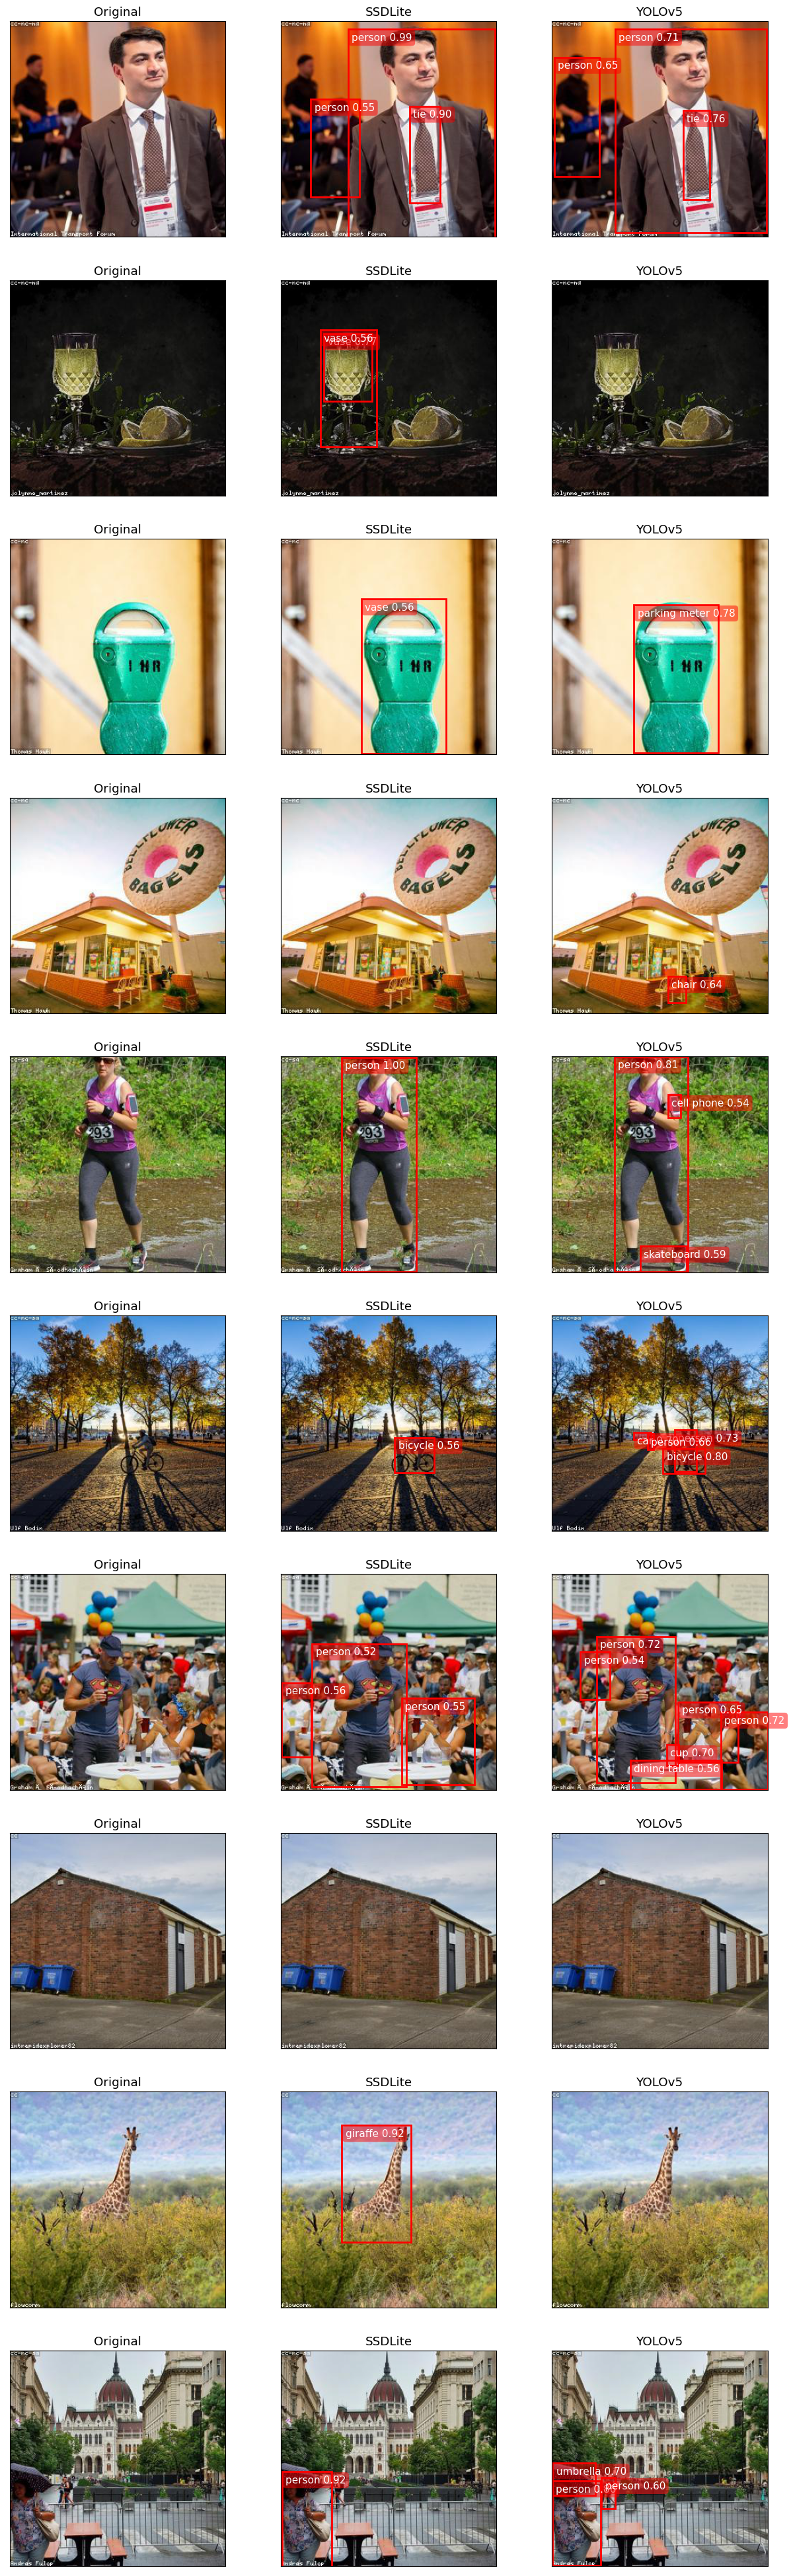

In [8]:
size_width = 5
score_threshold = 0.5
fig, ax = plt.subplots(
    ncols=3,
    nrows=len(os.listdir('test_images')),
    figsize=(3*size_width, N_images*size_width)
)
for i, path in enumerate(os.listdir('test_images')):

    img = read_image(f'test_images/{path}')

    ax[i, 0].set_title('Original')
    ax[i, 0].imshow(np.moveaxis(img.numpy(), 0, 2))
    ax[i, 0].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])    
    
    ssd_detection(f'test_images/{path}', ax=ax[i, 1], title='SSDLite', score_threshold=score_threshold)
    yolo_detection(f'test_images/{path}', ax=ax[i, 2], title='YOLOv5', score_threshold=score_threshold)

## 4 Разработка демо

Разработанное демо находится в файле `app/main.py`.

## 5 Встраивание модели-детектора в демо

Встроенная модель в демо находится в файле `app/main.py`.

## 6 Тестирование демо

Пример работы демо представлен в файле `example.gif`.

## 7 Оформление демо для показа другим людям

Оформленное демо представлено в `templates/index.html`.